# STOCK PREDICTION
### 0. [LIBRARY](#0)<br>
### 1. [FUNCTION](#1)<br>
- [Connect and get database from MySQL](#1a)<br>
- [Full data](#1b)<br>
- [Query data timeframe H1](#1c)<br>
- [Query highest price during the day timeframe H1](#1d)<br>
- [Query lowest price during the day timeframe H1](#1e)<br>
- [Create Sequences](#1g)<br>
### 2. [DATA PREPARATION](#2)<br>
- [Full data info](#2a)<br>
- [Data timeframe H1](#2b)<br>
### 3. [DATA ANALYSIS](#3)<br>
- [Frequency of highest price during the day](#3a)<br>
- [Frequency of lowest price during the day](#3b)<br>
### 4. [MODEL PREDICTION](#4)<br>
- [Scale and split data](#4a)
- [LSTM](#4b)
- [GRU](#4c)
- [ERROR](#4d)
- [Testing parameter](#4e)
- [Prediction](#4g)


# 0. LIBRARY : <a id="0"></a>

In [275]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import mysql.connector
import tensorflow as tf
from tensorflow.keras.layers import Dense, LSTM , GRU
from tensorflow.keras.models import Sequential
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import seaborn as sns
pd.options.mode.chained_assignment = None
tf.random.set_seed(0)

# 1. FUNCTION : <a id="1"></a> 

#####  1.Connect and get database from MySQL <a id="1a"></a>

In [276]:
def get_database_from_MySQL_after_query(host, user, password, database, sql_query):
    config = {
        "host": host,   
        "user": user,      
        "password": password, 
        "database": database     
    }
    conn = mysql.connector.connect(**config)
    cursor = conn.cursor()
    cursor.execute(sql_query)
    results = cursor.fetchall()
    column_names = [i[0] for i in cursor.description]
    conn.close()
    df = pd.DataFrame(results, columns=column_names)
    return df

##### 2.Full data <a id="1b"></a>

In [277]:
def Full_data():
    query = ''' select * from msn'''
    return query

##### 3.Data query timeframe H1 <a id="1c"></a>

In [278]:
def Query_data_H1():
    query = '''
        SELECT 
            DATE_FORMAT(open_time, '%Y-%m-%d %H') as open_time, 
            MIN(Low) as low,
            MAX(High) AS high,
            AVG(Volume) as volume
        FROM stock.msn 
        GROUP BY DATE_FORMAT(open_time, '%Y-%m-%d %H');
        '''
    return query

##### 4.Data query highest price during the day timeframe H1 <a id="1d"></a>

In [279]:
def Query_highest_price_H1():
    query = '''
        WITH CTE AS 
        (
            SELECT 
                DATE_FORMAT(open_time, '%Y-%m-%d %H') as open_time, 
                MIN(Low) as low,
                MAX(High) AS high,
                AVG(Volume) as volume
            FROM stock.msn 
            GROUP BY DATE_FORMAT(open_time, '%Y-%m-%d %H')
        ),
        latest_table AS
        (   
            WITH CTE1 AS
            (
                SELECT DATE(open_time) as ngay , MAX(high) AS gia
                FROM CTE
                GROUP BY DATE(open_time)
            )
            SELECT b.open_time AS OPEN_TIME, n.gia AS PRICE
            FROM CTE1 AS n
            INNER JOIN CTE AS b
            ON n.ngay = DATE(b.open_time) AND n.gia = b.high
        )
        SELECT HOUR(OPEN_TIME) AS "Thời Gian", COUNT(PRICE) AS "Số Lần"
        FROM latest_table 
        GROUP BY HOUR(OPEN_TIME)
        ORDER BY HOUR(OPEN_TIME) ASC;
        '''
    return query

##### 5.Data query lowest price during the day timeframe H1 <a id="1e"></a>

In [280]:
def Query_lowest_price_H1():
    query = '''
        WITH CTE AS 
        (
            SELECT 
                DATE_FORMAT(open_time, '%Y-%m-%d %H') AS open_time, 
                MIN(Low) AS low,
                MAX(High) AS high,
                AVG(Volume) AS volume
            FROM stock.msn 
            GROUP BY DATE_FORMAT(open_time, '%Y-%m-%d %H')
        ),
        latest_table AS
        (   
            WITH CTE1 AS
            (
                SELECT DATE(open_time) AS ngay , MIN(low) AS gia
                FROM CTE
                GROUP BY DATE(open_time)
            )
            SELECT b.open_time AS OPEN_TIME, n.gia AS PRICE
            FROM CTE1 AS n
            INNER JOIN CTE AS b
            ON n.ngay = DATE(b.open_time) AND n.gia = b.low
        )
        SELECT HOUR(OPEN_TIME) AS "Thời Gian", COUNT(PRICE) AS "Số Lần"
        FROM latest_table 
        GROUP BY HOUR(OPEN_TIME)
        ORDER BY HOUR(OPEN_TIME) ASC;
        '''
    return query

##### 6.Create sequences <a id="1g"></a>

In [281]:
def create_sequences(data, sequence_length):
    sequences = []
    for i in range(len(data) - sequence_length):
        seq = data[i:i+sequence_length]
        sequences.append(seq)
    return np.array(sequences)

# 2. DATA PREPARATION : <a id="2"></a> 

##### 1.Full data info: <a id="2a"></a>

In [282]:
df = get_database_from_MySQL_after_query("localhost","root","Khanhbg2522003","stock",Full_data())

In [283]:
df.head(5)

,Ticker,open_time,Open,High,Low,Close,Volume,Open Interest
0,MSN,2017-12-25 09:15:00,73.1,73.1,73.1,73.1,4210,0
1,MSN,2017-12-25 09:16:00,73.0,73.0,73.0,73.0,5000,0
2,MSN,2017-12-25 09:18:00,73.5,73.5,73.5,73.5,210,0
3,MSN,2017-12-25 09:20:00,73.2,73.5,73.1,73.1,2050,0
4,MSN,2017-12-25 09:21:00,73.0,73.0,73.0,73.0,1380,0


In [284]:
df.tail(5)

,Ticker,open_time,Open,High,Low,Close,Volume,Open Interest
135349,MSN,2020-12-22 14:23:00,82.8,82.8,82.8,82.8,700,0
135350,MSN,2020-12-22 14:24:00,82.7,82.8,82.7,82.8,4660,0
135351,MSN,2020-12-22 14:25:00,82.8,82.8,82.8,82.8,50,0
135352,MSN,2020-12-22 14:27:00,82.8,82.8,82.8,82.8,300,0
135353,MSN,2020-12-22 14:46:00,82.8,82.8,82.8,82.8,200,0


In [285]:
df.dtypes

Ticker            object
open_time         object
Open             float64
High             float64
Low              float64
Close            float64
Volume             int64
Open Interest      int64
dtype: object

In [286]:
df.isna().sum().sort_values(ascending=False)

Ticker           0
open_time        0
Open             0
High             0
Low              0
Close            0
Volume           0
Open Interest    0
dtype: int64

In [287]:
df.isna().sum().sort_values(ascending=False)

Ticker           0
open_time        0
Open             0
High             0
Low              0
Close            0
Volume           0
Open Interest    0
dtype: int64

In [288]:
df.describe()

,Open,High,Low,Close,Volume,Open Interest
count,135354.000000,135354.000000,135354.000000,135354.000000,1.353540e+05,135354.0
mean,74.878809,74.931668,74.834625,74.880759,5.683578e+03,0.0
std,15.418074,15.426954,15.412677,15.418857,2.798513e+04,0.0
min,46.500000,46.500000,46.400000,46.400000,1.000000e+01,0.0
25%,57.900000,57.900000,57.800000,57.800000,5.000000e+02,0.0
50%,79.100000,79.200000,79.100000,79.100000,2.000000e+03,0.0
75%,86.000000,86.100000,86.000000,86.000000,5.560000e+03,0.0
max,117.800000,118.000000,117.700000,118.000000,3.300680e+06,0.0


In [289]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 135354 entries, 0 to 135353
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Ticker         135354 non-null  object 
 1   open_time      135354 non-null  object 
 2   Open           135354 non-null  float64
 3   High           135354 non-null  float64
 4   Low            135354 non-null  float64
 5   Close          135354 non-null  float64
 6   Volume         135354 non-null  int64  
 7   Open Interest  135354 non-null  int64  
dtypes: float64(4), int64(2), object(2)
memory usage: 8.3+ MB


##### 2.Data timeframe H1: <a id="2b"></a>

In [290]:
df2 = get_database_from_MySQL_after_query("localhost","root","Khanhbg2522003","stock",Query_data_H1())

In [291]:
df2["open_time"] = pd.to_datetime(df2["open_time"])
df2.set_index('open_time', inplace=True)
df2.head(5)

,low,high,volume
open_time,,,
2017-12-25 09:00:00,73.0,73.5,2016.9565
2017-12-25 10:00:00,73.0,74.2,1705.3333
2017-12-25 11:00:00,73.5,74.1,2300.0000
2017-12-25 13:00:00,73.3,74.2,815.8621
2017-12-25 14:00:00,74.2,75.4,2928.0000


In [292]:
df2.tail(5)

,low,high,volume
open_time,,,
2020-12-22 09:00:00,82.8,84.0,5368.8372
2020-12-22 10:00:00,83.1,83.5,1960.5556
2020-12-22 11:00:00,82.8,83.3,5269.3103
2020-12-22 13:00:00,82.5,82.9,4460.6780
2020-12-22 14:00:00,82.6,82.9,1876.0714


In [293]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3733 entries, 2017-12-25 09:00:00 to 2020-12-22 14:00:00
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   low     3733 non-null   float64
 1   high    3733 non-null   float64
 2   volume  3733 non-null   object 
dtypes: float64(2), object(1)
memory usage: 116.7+ KB


# 3. DATA ANALYSIS : <a id="3"></a> 

##### 1.Frequency of highest price during the day: <a id="3a"></a>

In [294]:
df_highest = get_database_from_MySQL_after_query("localhost","root","Khanhbg2522003","stock",Query_highest_price_H1())

In [295]:
df_highest.head()

,Thời Gian,Số Lần
0,9,397
1,10,131
2,11,47
3,13,141
4,14,178


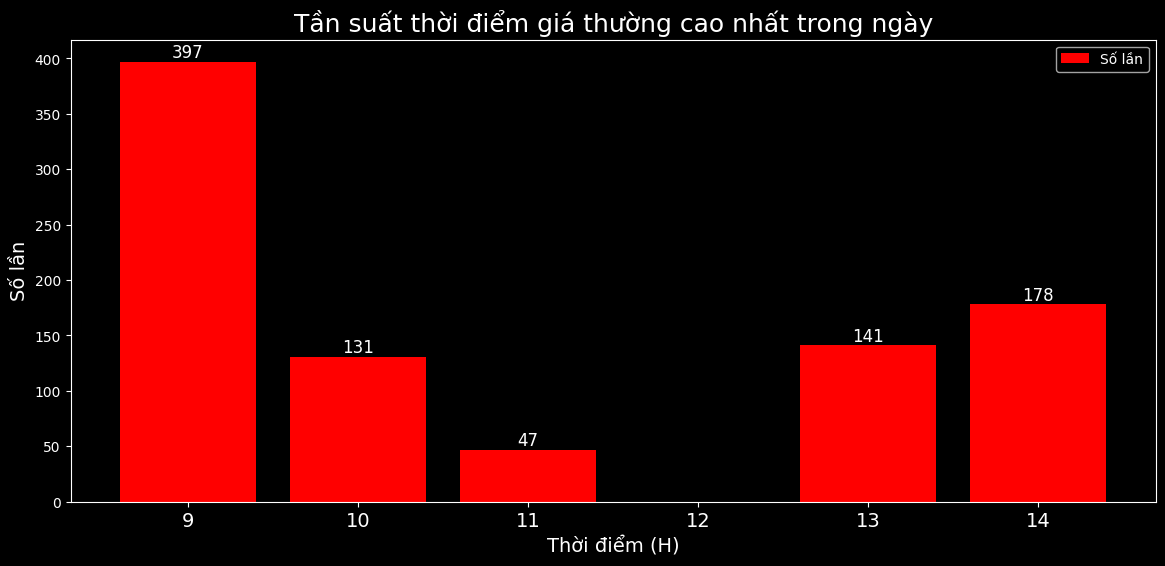

In [296]:
plt.figure(figsize=(14,6))
bars = plt.bar(df_highest["Thời Gian"], df_highest["Số Lần"], label="Số lần",color="red")
plt.title("Tần suất thời điểm giá thường cao nhất trong ngày", fontsize=18)
plt.xlabel("Thời điểm (H)",fontsize=14)
plt.ylabel("Số lần",fontsize=14)
plt.xticks(fontsize=14)
plt.legend()
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval, round(yval, 2), ha='center', va='bottom', fontsize=12, color='white')

##### 2.Frequency of lowest price during the day: <a id="3b"></a>

In [297]:
df_lowest = get_database_from_MySQL_after_query("localhost","root","Khanhbg2522003","stock",Query_lowest_price_H1())

In [298]:
df_lowest

,Thời Gian,Số Lần
0,9,364
1,10,121
2,11,70
3,13,141
4,14,253


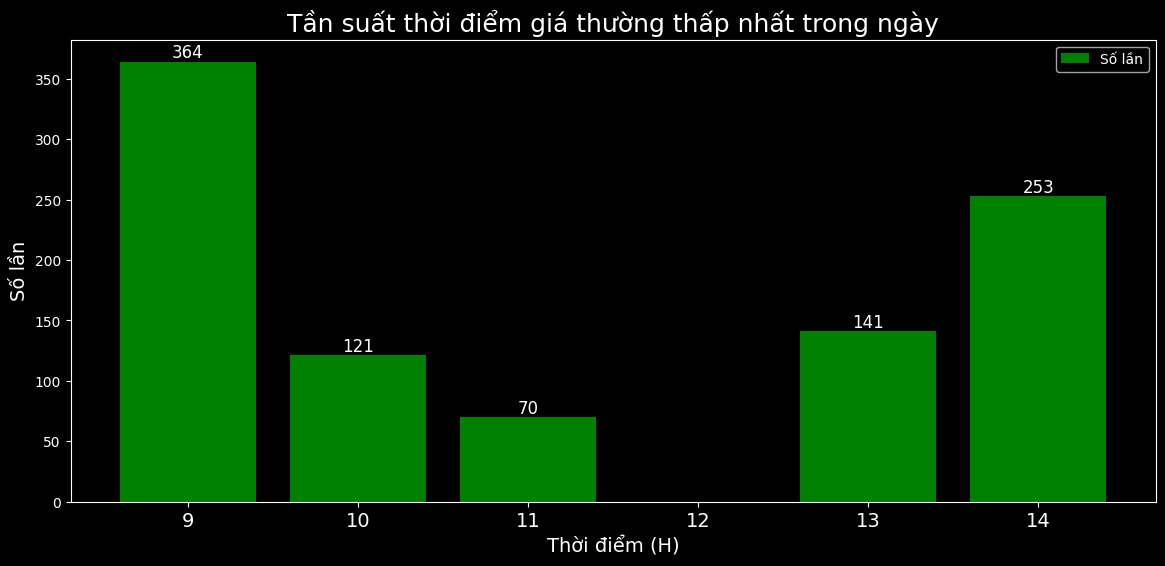

In [299]:
plt.figure(figsize=(14,6))
bars = plt.bar(df_lowest["Thời Gian"], df_lowest["Số Lần"], label="Số lần",color="green")
plt.title("Tần suất thời điểm giá thường thấp nhất trong ngày", fontsize=18)
plt.xlabel("Thời điểm (H)",fontsize=14)
plt.ylabel("Số lần",fontsize=14)
plt.xticks(fontsize=14)
plt.legend()
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval, round(yval, 2), ha='center', va='bottom', fontsize=12, color='white')

# 4. MODEL PREDICTION : <a id="4"></a> 

##### 1.Scale and split data: <a id="4a"></a>

In [300]:
high_price = df2['high'].values.reshape(-1, 1)
scaler = MinMaxScaler()
scaled_prices = scaler.fit_transform(high_price)
train_size = int(len(scaled_prices) * 0.8)
train_data = scaled_prices[:train_size]
test_data = scaled_prices[train_size:]

sequence_length = 60

##### 2.LSTM: <a id="4b"></a>

In [314]:
X_train_lstm = create_sequences(train_data, sequence_length)
X_test_lstm = create_sequences(test_data, sequence_length)
lstm_model = tf.keras.Sequential([
    tf.keras.layers.LSTM(50, activation='relu', input_shape=(sequence_length, 1), return_sequences=True),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.LSTM(50, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1)
])

lstm_model.compile(optimizer='adam', loss='mean_squared_error')

lstm_model.fit(X_train_lstm, train_data[sequence_length:], epochs=80, batch_size=32)

y_test_lstm = lstm_model.predict(X_test_lstm).reshape(-1, 1)
mse_lstm = mean_squared_error(y_test_actual, y_test_lstm)

predicted_scaled_prices_lstm = lstm_model.predict(X_test_lstm)
predicted_prices_lstm = scaler.inverse_transform(predicted_scaled_prices_lstm)

Epoch 1/80
92/92 [==============================] - 8s 55ms/step - loss: 0.0312
Epoch 2/80
92/92 [==============================] - 5s 54ms/step - loss: 0.0043
Epoch 3/80
92/92 [==============================] - 5s 52ms/step - loss: 0.0041
Epoch 4/80
92/92 [==============================] - 5s 50ms/step - loss: 0.0037
Epoch 5/80
92/92 [==============================] - 5s 51ms/step - loss: 0.0033
Epoch 6/80
92/92 [==============================] - 5s 50ms/step - loss: 0.0034
Epoch 7/80
92/92 [==============================] - 5s 53ms/step - loss: 0.0031
Epoch 8/80
92/92 [==============================] - 5s 53ms/step - loss: 0.0031
Epoch 9/80
92/92 [==============================] - 5s 50ms/step - loss: 0.0031
Epoch 10/80
92/92 [==============================] - 5s 53ms/step - loss: 0.0028
Epoch 11/80
92/92 [==============================] - 5s 50ms/step - loss: 0.0025
Epoch 12/80
92/92 [==============================] - 5s 50ms/step - loss: 0.0026
Epoch 13/80
92/92 [==================

##### 3.GRU: <a id="4c"></a>

In [310]:
X_train_gru = create_sequences(train_data, sequence_length)
X_test_gru = create_sequences(test_data, sequence_length)
gru_model = tf.keras.Sequential([
    tf.keras.layers.GRU(50, activation='relu', input_shape=(sequence_length, 1), return_sequences=True),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.GRU(50, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1)
])

gru_model.compile(optimizer='adam', loss='mean_squared_error')

gru_model.fit(X_train_gru, train_data[sequence_length:], epochs=100, batch_size=32, verbose=0)

X_test_gru = create_sequences(test_data, sequence_length)
y_test_actual = test_data[sequence_length:]
y_test_gru = gru_model.predict(X_test_gru).reshape(-1, 1)


mse_gru = mean_squared_error(y_test_actual, y_test_gru)

predicted_scaled_prices_gru = gru_model.predict(X_test_gru)
predicted_prices_gru = scaler.inverse_transform(predicted_scaled_prices_gru)


22/22 [==============================] - 0s 15ms/step


##### 4.ERROR: <a id="4d"></a>

In [315]:
print(f'Mean Squared Error (LSTM): {mse_lstm}')
print(f'Mean Squared Error (GRU): {mse_gru}')

Mean Squared Error (LSTM): 0.0004328345509141703
Mean Squared Error (GRU): 0.000248389563732974


##### 5.Testing parameter: <a id="4e"></a>

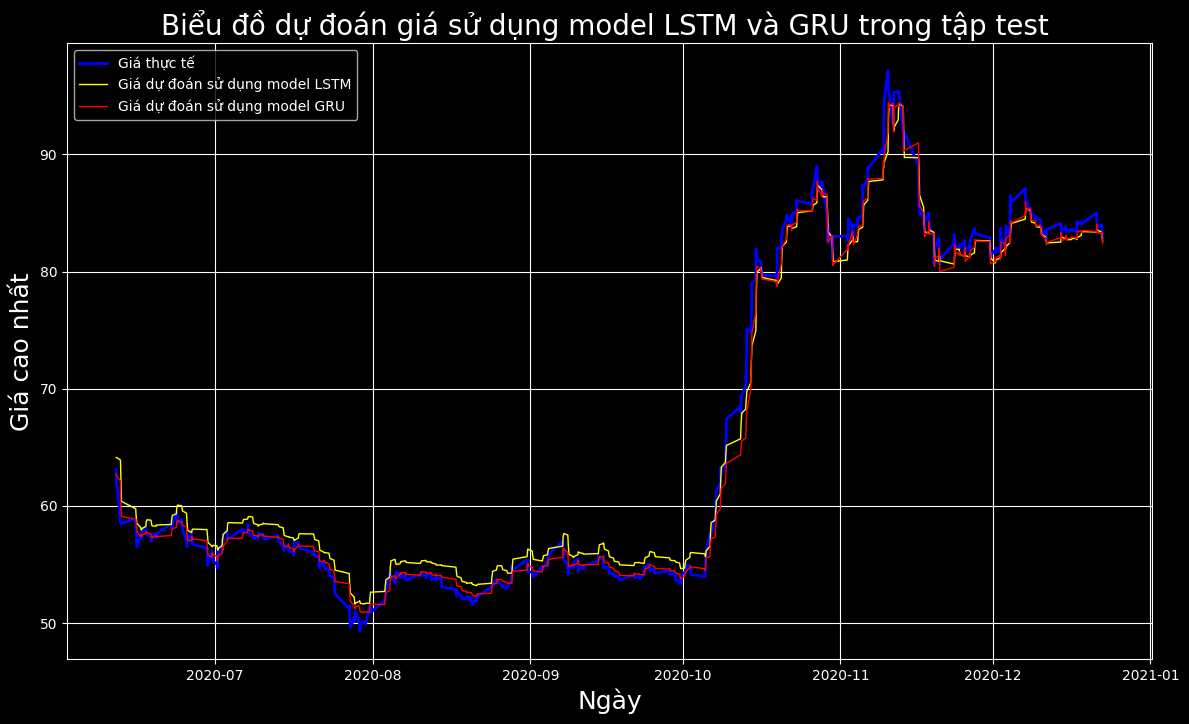

In [318]:
plt.style.use('dark_background')
plt.figure(figsize=(14, 8))
plt.plot(df2.index[train_size+sequence_length:], high_price[train_size+sequence_length:],color='blue', label='Giá thực tế',linewidth=2)
plt.plot(df2.index[train_size+sequence_length:], predicted_prices_lstm, label='Giá dự đoán sử dụng model LSTM', color='yellow',linestyle='-',linewidth=1)
plt.plot(df2.index[train_size+sequence_length:], predicted_prices_gru, label='Giá dự đoán sử dụng model GRU', color='red',linestyle='-',linewidth=1)
plt.title('Biểu đồ dự đoán giá sử dụng model LSTM và GRU trong tập test ',fontsize=20)
plt.xlabel('Ngày',fontsize=18)
plt.ylabel('Giá cao nhất',fontsize=18)
plt.legend(loc='upper left')
plt.grid(True)
plt.show()

##### 6.Prediction: <a id="4g"></a>

2/2 [==============================] - 0s 16ms/step


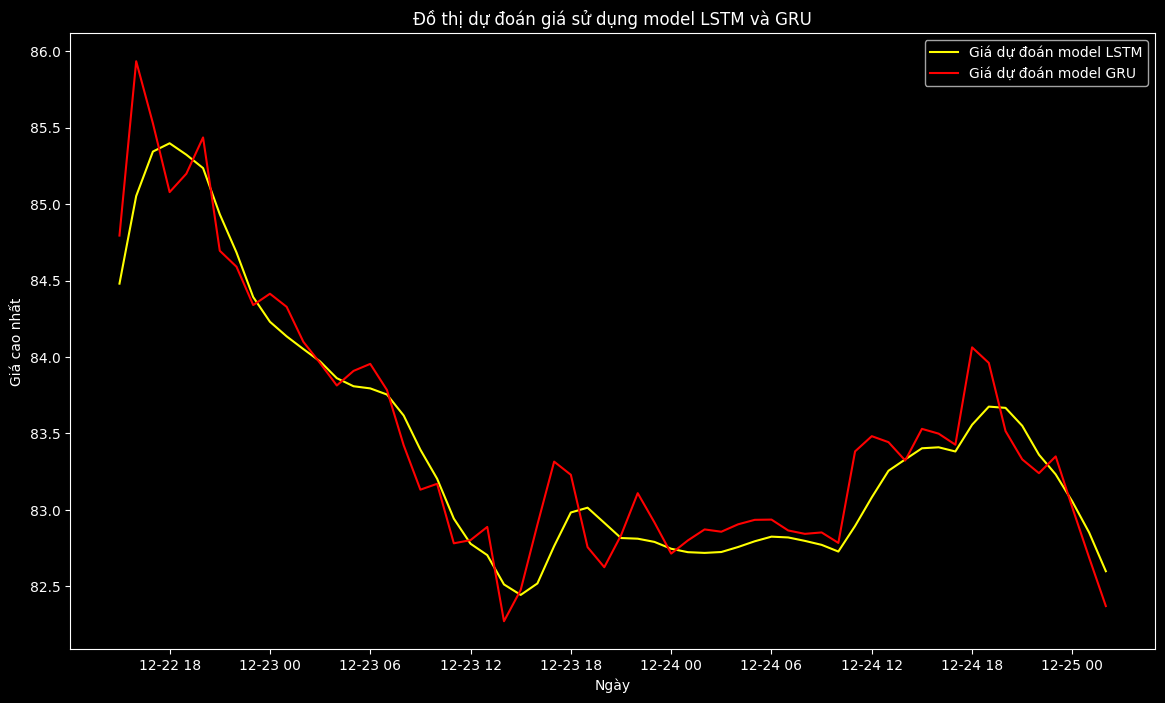

In [319]:
full_train_data = scaled_prices
X_full_train = create_sequences(full_train_data, sequence_length)
future_predictions_scaled_lstm = lstm_model.predict(X_full_train[-60:])
future_predictions_scaled_gru = gru_model.predict(X_full_train[-60:])

full_train_data = scaled_prices

X_full_train = create_sequences(full_train_data, sequence_length)

future_predictions_scaled_lstm = lstm_model.predict(X_full_train[-60:])
future_predictions_scaled_gru = gru_model.predict(X_full_train[-60:])
future_predictions_lstm = scaler.inverse_transform(future_predictions_scaled_lstm)
future_predictions_gru = scaler.inverse_transform(future_predictions_scaled_gru)

plt.figure(figsize=(14, 8))
plt.plot(pd.date_range(start=df2.index[-1], periods=61, freq='H')[1:], future_predictions_lstm, label='Giá dự đoán model LSTM', color='yellow')
plt.plot(pd.date_range(start=df2.index[-1], periods=61, freq='H')[1:], future_predictions_gru, label='Giá dự đoán model GRU', color='red')
plt.title('Đồ thị dự đoán giá sử dụng model LSTM và GRU')
plt.xlabel('Ngày')
plt.ylabel('Giá cao nhất')
plt.legend()
plt.show()

